# Fitting Biking Parameters to Data

See: https://www.gribble.org/cycling/power_v_speed.html for source of equations

In [3]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

def debug(fn):
    def wrap(*args, **kwargs):
        out = fn(*args, **kwargs)
        print(f'{fn.__name__}: {out}')
        return out
    return wrap

# @debug
def f_gravity(grade, weight_kg):
    return 9.8067 * jnp.sin(jnp.arctan(grade / 100)) * weight_kg

# @debug
def f_rolling(grade, weight_kg, c_rr):
    return 9.8067 * jnp.cos(jnp.arctan(grade / 100)) * weight_kg * c_rr

# @debug
def f_drag(v_headwind, v_groundspeed, cda, rho):
    v_airspeed = v_headwind + v_groundspeed
    return 0.5 * cda * rho * v_airspeed**2

def power_required(grade, weight_kg, c_rr, v_headwind, v_groundspeed, cda, rho, loss_drivetrain):
    return (1 - loss_drivetrain / 100)**(-1) * (
        f_gravity(grade=grade, weight_kg=weight_kg)
        + f_rolling(grade=grade, weight_kg=weight_kg, c_rr=c_rr)
        + f_drag(v_headwind=v_headwind, v_groundspeed=v_groundspeed, cda=cda, rho=rho)
    ) * v_groundspeed

test_pr = power_required(
    grade=1,
    weight_kg=82.5538,
    c_rr=0.005,
    v_headwind=0,
    v_groundspeed=6.73, # m/s
    cda=0.3207,  # m^2
    rho=1.22601,  # kg/m^3
    loss_drivetrain=2,
)
assert abs(test_pr.item() - 144.539) < 0.1

In [7]:
from datetime import timedelta
import fitparse
from collections import deque

def mean(lst):
    lst = list(lst)
    return sum(lst) / len(lst)

def safe(x):
    if abs(x) < 1e-12:
        return 1e-12
    return x

X = []
for filename in ["pavement_ends.fit", 'recent_road.fit']:
    # Load the FIT file
    fitfile = fitparse.FitFile(filename)

    # Iterate over all messages of type "record"
    # (other types include "device_info", "file_creator", "event", etc)
    queue = deque()
    last_altitude = None
    last_distance = None
    for t, record in enumerate(fitfile.get_messages("record")):

        # Records can contain multiple pieces of data (ex: timestamp, latitude, longitude, etc)
        timestamp = None
        power = None
        speed = None
        altitude = None
        distance = None
        for data in record:
            # Print the name and value of the data (and the units if it has any)
            # if data.units:
            #     print(" * {}: {} ({})".format(data.name, data.value, data.units))
            # else:
            #     print(" * {}: {}".format(data.name, data.value))
            if data.name == 'timestamp':
                timestamp = data.value
            if data.name == 'power':
                power = data.value
            if data.name == 'enhanced_speed':
                speed = data.value
            if data.name == 'enhanced_altitude':
                altitude = data.value
            if data.name == 'distance':
                distance = data.value
        if timestamp is not None and power is not None and speed is not None and last_altitude is not None and last_distance is not None and distance is not None and altitude is not None and distance > last_distance:
            grade = (altitude - last_altitude) / (distance - last_distance) * 100
            queue.append((timestamp, power, speed, grade))
            while timestamp - queue[0][0] > timedelta(seconds=3):
                queue.popleft()
            timespan = queue[-1][0] - queue[0][0]
            if timespan > timedelta(seconds=2):
                if all(
                    abs(dp[k] / safe(mean(dpm[k] for dpm in queue)) - 1) < 0.05
                    for k in range(1, 4)
                    for dp in queue
                ):
                    vec = [mean(dpm[k] for dpm in queue) for k in range(1, 4)]
                    # print(vec)
                    X.append(vec)
        if altitude is not None and distance is not None:
            last_altitude = altitude
            last_distance = distance

X = jnp.array(X)
print(X.shape)  # [# datapoints, (power, speed, grade)]

(103, 3)


In [110]:
# import optax
# import jax

# learning_rate = 1.25e-7
# optimizer = optax.sgd(learning_rate)
# # Obtain the `opt_state` that contains statistics for the optimizer.
# params = {'c_rr': jnp.ones((1,)) * 0.005, 'cda': jnp.ones((1,)) * 0.3207}
# opt_state = optimizer.init(params)

# def loss_fn(params):
#     pred_power = power_required(
#         grade=X[:, 2],
#         weight_kg=82.5,
#         c_rr=params['c_rr'],
#         v_headwind=0,
#         v_groundspeed=X[:, 1], # m/s
#         cda=params['cda'],  # m^2
#         rho=1.22601,  # kg/m^3
#         loss_drivetrain=2,
#     )
#     actual_power = X[:, 0]
#     diff = (pred_power - actual_power)
#     return (diff * diff).mean()  # MSE

# for i in range(10000):
#     value, grads = jax.value_and_grad(loss_fn)(params)
#     if i % 1000 == 0:
#         print(i, value)
#     updates, opt_state = optimizer.update(grads, opt_state)
#     params = optax.apply_updates(params, updates)
# print(value)

In [111]:
# params

In [8]:
from functools import partial

def cossim(x, y):
    return jnp.dot(x, y) / jnp.sqrt(jnp.dot(x, x) * jnp.dot(y, y))

def line_cda_crr(
    power,
    v_groundspeed, # m/s
    grade,
    weight_kg,
    v_headwind,
    rho,  # kg/m^3
    loss_drivetrain,
):
    # print(power, v_groundspeed, grade)
    c_dt = (1 - loss_drivetrain / 100)**-1 * v_groundspeed
    c_g = 9.8067 * weight_kg
    c_rhs = c_dt * c_g * jnp.sin(jnp.arctan(grade / 100))
    c_c_rr = c_dt * c_g * jnp.cos(jnp.arctan(grade / 100))
    c_cda = c_dt * 0.5 * rho * (v_headwind + v_groundspeed)**2
    c_lhs = power
    c = c_lhs - c_rhs
    return ([c_cda, c_c_rr], c)


partial_line = partial(line_cda_crr, 
        weight_kg=82.5,
        v_headwind=0,
        rho=1.22601,  # kg/m^3
        loss_drivetrain=2
)

A = []
b = []
for i in range(X.shape[0]):
    aa, bb = partial_line(*X[i])
    aa = jnp.stack(aa)
    A.append(aa)
    b.append(bb)
A = jnp.stack(A, 0)
b = jnp.array(b)

# sims = []
# for i in range(A.shape[0]):
#     for j in range(i + 1, A.shape[0]):
#         Asub = A[jnp.array([i, j])]
#         bsub = b[jnp.array([i, j])]
#         sims.append((cossim(Asub[0], Asub[1]), Asub, bsub))
#         # print(Asub[0], Asub[1], cossim(Asub[0], Asub[1]))
#         # if cossim(Asub[0], Asub[1]) > 0.99:
#         #     continue
#         # print(Asub.shape, bsub.shape)
#         # solved = jnp.linalg.solve(Asub, bsub)
#         # print(solved)
#         # blahh
# _, Asub, bsub = min(sims, key=lambda x: x[0])
# solved = jnp.linalg.solve(Asub, bsub)
# print(solved)

In [10]:
from sklearn.linear_model import LinearRegression

# lr = LinearRegression(fit_intercept=False)
# lr.fit(A, b)
# lr.coef_

In [11]:
from sklearn.ensemble import BaggingRegressor

reg = BaggingRegressor(LinearRegression(fit_intercept=False), max_samples=20, n_estimators=200)
reg.fit(A, b)


BaggingRegressor(estimator=LinearRegression(fit_intercept=False),
                 max_samples=20, n_estimators=200)

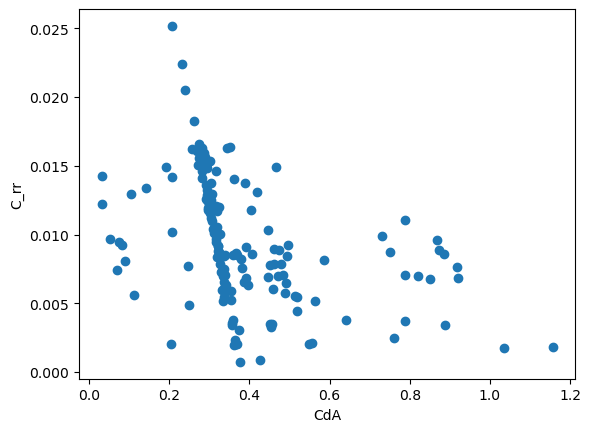

[0.38901642 0.00920373] +- [0.03021691 0.00069702]


In [12]:
import numpy as np
import scipy.stats as stats

theta = np.stack([estim.coef_ for estim in reg.estimators_], 0)
theta = theta[np.all(theta > 0, 1)]
plt.scatter(theta[:, 0], theta[:, 1])
plt.xlabel('CdA')
plt.ylabel('C_rr')
plt.show()

sem = theta.std(0) / np.sqrt(theta.shape[0])
confidence_level = 0.95
degrees_freedom = theta.shape[0] - 1
critical_value = stats.t.ppf((1 + confidence_level) / 2, degrees_freedom)
margin_of_error = critical_value * sem

cda, crr = theta.mean(0).tolist()
print(f'{theta.mean(0)} +- {margin_of_error}')

In [93]:
0.31893608 / 0.636

0.5014718238993711

Pretty good estimate: [calculator](https://www.gribble.org/cycling/power_v_speed.html?units=imperial&rp_wr=159.835&rp_wb=22.046&rp_a=7.7931&rp_cd=0.636&rp_dtl=2&ep_crr=0.01&ep_rho=0.076537&ep_g=0&ep_headwind=0&p2v=200&v2p=22)

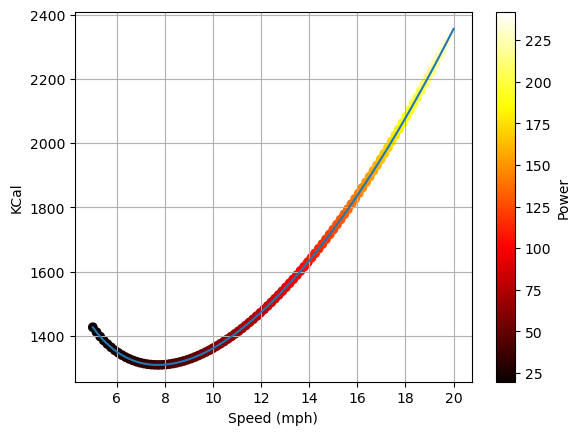

In [13]:
# For constant 50 miles, what's the most efficient speed to go?
groundspeed_mph = jnp.linspace(5, 20, 100)
groundspeed_mps = groundspeed_mph / 2.23694
power = power_required(
    grade=0,
    weight_kg=82.5,
    c_rr=crr,
    v_headwind=0,
    v_groundspeed=groundspeed_mps, # m/s
    cda=cda,  # m^2
    rho=1.22601,  # kg/m^3
    loss_drivetrain=2,
)

time_for_distance = 50 / groundspeed_mph * 3600
bmr = 19.93  # https://www.garnethealth.org/news/basal-metabolic-rate-calculator then cals * 1000 / (3600 * 24)
cals = (time_for_distance * (power + bmr)) / 1000

plt.plot(groundspeed_mph, cals)
plt.scatter(groundspeed_mph, cals, c=power, cmap='hot')
plt.colorbar(label='Power')
plt.grid()
plt.ylabel('KCal')
plt.xlabel('Speed (mph)')
plt.show()

In [15]:

def compute(grade, distance_miles):
    groundspeed_mph = jnp.linspace(5, 45, 1000)
    groundspeed_mps = groundspeed_mph / 2.23694
    power = power_required(
        grade=grade,
        weight_kg=82.5,
        c_rr=crr,
        v_headwind=0,
        v_groundspeed=groundspeed_mps, # m/s
        cda=cda,  # m^2
        rho=1.22601,  # kg/m^3
        loss_drivetrain=2,
    )
    mask = power >= 0
    power = power[mask]
    groundspeed_mph = groundspeed_mph[mask]
    if np.count_nonzero(mask) == 0:
        return None, None

    time_for_distance = distance_miles / groundspeed_mph * 3600
    bmr = 19.93  # https://www.garnethealth.org/news/basal-metabolic-rate-calculator then cals * 1000 / (3600 * 24)
    cals = (time_for_distance * (power + bmr)) / 1000
    i = jnp.argmin(cals)
    return power[i], groundspeed_mph[i]

all_grades = jnp.linspace(-15, 15, 100)
grades = []
powers = []
speeds = []
for grade in all_grades:
    p, s = compute(grade, 50)
    if p is not None and s is not None:
        grades.append(grade)
        powers.append(p)
        speeds.append(s)

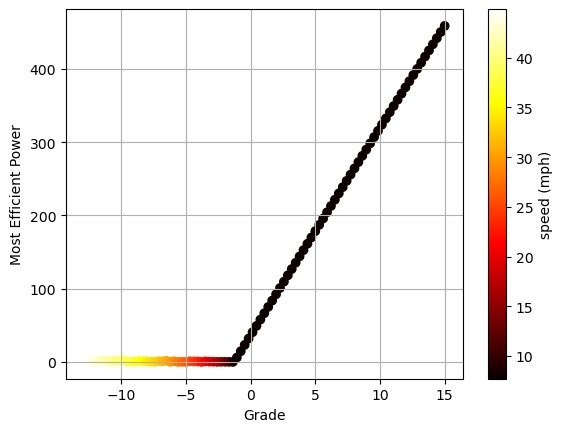

In [16]:
plt.scatter(grades, powers, c=speeds, cmap='hot')
plt.colorbar(label='speed (mph)')
plt.ylabel('Most Efficient Power')
plt.xlabel('Grade')
plt.grid()
plt.show()

7.7227216 9.536743e-07


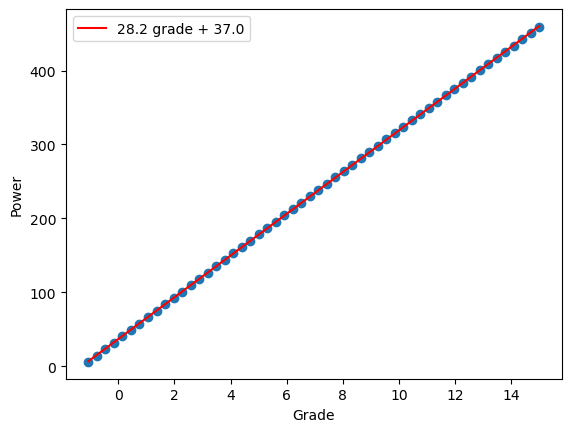

In [17]:
import numpy as np

p = np.array(powers)
g = np.array(grades)
m = p > 5
p = p[m]
g = g[m]
s = np.array(speeds)[m]
print(np.mean(s), np.std(s))
plt.scatter(g, p)

lr = LinearRegression(fit_intercept=True)
lr.fit(np.expand_dims(g, 1), p)
m = lr.coef_[0]
b = lr.intercept_
x = np.linspace(np.min(g), np.max(g), 10)
plt.plot(x, m * x + b, c='r', label=f'{m:.1f} grade + {b:.1f}')

plt.ylabel('Power')
plt.xlabel('Grade')

plt.legend()
plt.show()